<a href="https://colab.research.google.com/github/yanhao5103233729/multiModal/blob/main/1218%E5%A4%9A%E6%A8%A1%E6%80%81%E6%B3%A2%E6%9D%9F%E9%A2%84%E6%B5%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
# 导入必要库
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as trn
from torchvision import models
from tqdm import tqdm
import pandas as pd
import os
import math
import joblib
import scipy.io as scipyio
import matplotlib.pyplot as plt
from datetime import datetime
import gc

In [ ]:
!pip install ultralytics
from ultralytics import YOLO

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu116
!pip install matplotlib==3.7.2
!pip install numpy==1.22.0
!pip install opencv-python==4.8.0.74

In [ ]:
!git clone https://github.com/facebookresearch/segment-anything.git
# Download the link under './segment-anything/'
# https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
import sys
sys.path.append('./segment-anything')
from segment_anything import sam_model_registry, SamPredictor

In [32]:
# 定义神经网络组件
class Cross_EncoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, n_head, drop_prob):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=n_head)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(p=drop_prob)
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.linear1 = nn.Linear(d_model, ffn_hidden)
        self.linear2 = nn.Linear(ffn_hidden, d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, seq1,seq2):
        _x = seq1
        x,_ = self.attention(query=seq1, key=seq2, value=seq2)
        x = self.dropout1(x)
        x = self.norm1(x + _x)
        _x = x
        x = self.linear2(self.dropout(nn.functional.relu(self.linear1(x))))
        x = self.dropout2(x)
        x = self.norm2(x + _x)
        return x

class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        # 初始化Shape为(max_len, d_model)的PE (positional encoding)
        pe = torch.zeros(max_len, d_model)
        # 初始化一个tensor [[0, 1, 2, 3, ...]]
        position = torch.arange(0, max_len).unsqueeze(1)
        # 这里就是sin和cos括号中的内容，通过e和ln进行了变换
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        # 计算PE(pos, 2i)
        pe[:, 0::2] = torch.sin(position * div_term)
        # 计算PE(pos, 2i+1)
        pe[:, 1::2] = torch.cos(position * div_term)
        # 为了方便计算，在最外面在unsqueeze出一个batch
        pe = pe.unsqueeze(0)
        # 如果一个参数不参与梯度下降，但又希望保存model的时候将其保存下来
        # 这个时候就可以用register_buffer
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x 为embedding后的inputs，例如(1,7, 128)，batch size为1,7个单词，单词维度为128
        """
        # 将x和positional encoding相加
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

class attention(nn.Module):
    def __init__(self, d_model, nhead, batch_size, sequence_length):
        super().__init__()
        self.dim = d_model
        self.heads = nhead
        self.batch = batch_size
        self.seq = sequence_length
        self.PE = PositionalEncoding(self.dim, dropout=0)
        self.encoder_layer = nn.TransformerEncoderLayer(self.dim, self.heads)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        self.atte = nn.MultiheadAttention(self.dim, self.heads)
        self.linear=nn.Linear(self.seq * 64,2048)
        self.predictor = nn.Linear(2048, 64)

    def forward(self, input):
        input = input.view(self.batch, -1, self.dim)
        # print(input.shape)
        input = self.PE(input.transpose(0, 1))  # 输入数据的形状：(sequence_length, batch_size, d_model)
        output = self.encoder(input)
        # print(output.shape)
        output = self.linear(output.permute(1, 0, 2).reshape(self.batch, -1))  # batch*64
        output=self.predictor(F.relu(output))
        #output=output.permute(1, 0, 2)
        return output

class cross_attention(nn.Module):
    def __init__(self, d_model, nhead, batch_size, sequence_length):
        super().__init__()
        self.dim = d_model
        self.heads = nhead
        self.batch = batch_size
        self.seq = sequence_length
        self.PE = PositionalEncoding(self.dim, dropout=0)
        self.encoder_layer1 = Cross_EncoderLayer(self.dim, 2048,self.heads,0.1)
        self.encoder_layer2 = Cross_EncoderLayer(self.dim, 2048, self.heads, 0.1)
        #self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        self.atte = nn.MultiheadAttention(self.dim, self.heads)
        self.predictor = nn.Linear(2048, 64)
        self.linear1=nn.Linear((226+51)*64,2048)
        self.relu_layer = nn.ReLU()
    def forward(self, input1,input2):
        #input1 = input1.view(self.batch, -1, self.dim)
        #input2 = input2.view(self.batch, -1, self.dim)
        # print(input.shape)
        #input = self.PE(input.transpose(0, 1))  # 输入数据的形状：(sequence_length, batch_size, d_model)
        #output = torch.cat((input1,input2),dim=0)
        output = self.encoder_layer1(input1,input2)+input1
        output = self.encoder_layer2(output, input2)+output
        #output=torch.cat((input1,input2),dim=0)
        output=self.relu_layer(self.linear1(output.permute(1, 0, 2).reshape(self.batch, -1)))
        # print(output.shape)
        output = self.predictor(output)  # batch*64
        return output

In [33]:
# 初始化模型
batch = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_rgb = attention(64, 8, batch, 226).to(device)
model_radar = attention(64, 8, batch, 51).to(device)
model_fusion = cross_attention(64, 8, batch, 226).to(device)
forward = nn.Linear(4, 64)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(list(model_rgb.parameters()) + list(forward.parameters()), lr=1e-5, weight_decay=0.02)

In [34]:
# 定义数据集类
class My_dataset(Dataset):
    def __init__(self, x, y):
        self.data1 = x[0]
        self.data2 = x[1]
        self.labels = y

    def __len__(self):
        return len(self.data1)

    def __getitem__(self, item):
        return self.data1[item], self.data2[item], self.labels[item]

In [35]:
# 定义图像数据辅助函数
transform_train = trn.Compose([
    trn.Resize(256),
    trn.RandomResizedCrop(224),
    trn.ToTensor(),
    trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def pic_process(input):
    input = input.convert('RGB')
    output = transform_train(input)
    return output

def resnet_img(model, input_x):
    for param in model.parameters():
        param.requires_grad = False
    x = model.conv1(input_x)
    x = model.bn1(x)
    x = model.relu(x)
    x = model.maxpool(x)
    x = model.layer1(x)
    x = model.layer2(x)
    x = model.layer3(x)
    x = model.layer4(x)
    x = model.avgpool(x)
    return x

In [36]:
# 定义雷达数据辅助函数
RADAR_PARAMS = {
    'chirps': 128, 'tx': 1, 'rx': 4, 'samples': 256, 'adc_sampling': 5e6,
    'chirp_slope': 15.015e12, 'start_freq': 77e9, 'idle_time': 5, 'ramp_end_time': 60
}
samples_per_chirp = RADAR_PARAMS['samples']
n_chirps_per_frame = RADAR_PARAMS['chirps']
C = 3e8
chirp_period = (RADAR_PARAMS['ramp_end_time'] + RADAR_PARAMS['idle_time']) * 1e-6
RANGE_RES = ((C * RADAR_PARAMS['adc_sampling']) / (2 * RADAR_PARAMS['samples'] * RADAR_PARAMS['chirp_slope']))
VEL_RES_KMPH = 3.6 * C / (2 * RADAR_PARAMS['start_freq'] * chirp_period * RADAR_PARAMS['chirps'])
min_range_to_plot = 5
max_range_to_plot = 15
acquired_range = samples_per_chirp * RANGE_RES
first_range_sample = np.ceil(samples_per_chirp * min_range_to_plot / acquired_range).astype(int)
last_range_sample = np.ceil(samples_per_chirp * max_range_to_plot / acquired_range).astype(int)
round_min_range = first_range_sample / samples_per_chirp * acquired_range
round_max_range = last_range_sample / samples_per_chirp * acquired_range

def range_velocity_map(data):
    data = np.fft.fft(data, axis=1)
    data = np.fft.fft(data, axis=2)
    data = np.fft.fftshift(data, axes=2)
    data = np.abs(data).sum(axis=0)
    data = np.log(1 + data)
    return data

def range_angle_map(data, fft_size=64):
    data = np.fft.fft(data, axis=1)
    data -= np.mean(data, 2, keepdims=True)
    data = np.fft.fft(data, fft_size, axis=0)
    data = np.fft.fftshift(data, axes=0)
    data = np.abs(data).sum(axis=2)
    return data.T

In [ ]:
# 数据加载和预处理
# Download the link under './'
# https://www.deepsense6g.net/?smd_process_download=1&download_id=184643
dataframe = pd.read_csv('./scenario9_dev/scenario9.csv')
rgb_paths = dataframe['unit1_rgb'].values
radar_paths = dataframe['unit1_radar'].values
beam_label = dataframe['unit1_beam_index'].values
dataset = My_dataset([rgb_paths, radar_paths], beam_label)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
data_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, drop_last=True)
valid_loader = DataLoader(test_dataset, batch_size=batch, shuffle=True, drop_last=True)

In [38]:
# 定义辅助函数
def top_k_accuracy(output, target, k=1):
    with torch.no_grad():
        pred = torch.topk(output, k, dim=1)[1]
        correct = pred.eq(target.view(-1, 1).expand_as(pred))
        correct_k = correct.view(-1).float().sum(0, keepdim=True)
    return correct_k.item()

In [39]:
# 初始化性能记录列表
top1_acc_loss = []
top3_acc_loss = []
top5_acc_loss = []

In [ ]:
# 训练循环
Epochs = 50
for epoch in range(Epochs):
    gc.collect()
    torch.cuda.empty_cache()
    total_train_loss = 0
    # 训练阶段
    for path1,path2, label in tqdm(data_loader, desc=f"Epoch {epoch + 1}"):
        model_rgb.train()
        # model_radar.train()
        # model_fusion.train()
        forward.train()
        img = []
        masks = []
        bbox = []
        radar=[]
        for i in path1:
            # origin_img = Image.open(i)
            # pro_img = pic_process(origin_img)
            # img.append(pro_img)

            txt = pd.read_csv(
                filepath_or_buffer='./runs/detect/predict/labels/' + i.split("/")[-1].split(".")[0] + '.txt',
                header=None, sep=' ')
            txt = txt[txt[0] == 2]
            txt = txt.values  # class, x_center, y_center, width, height
            txt[:, 1] *= 960 / 6
            txt[:, 2] *= 540 / 6
            txt[:, 3] *= 960 / 6
            txt[:, 4] *= 540 / 6
            for num in range(txt.shape[0]):
                if num == 1:
                    [x, y, w, h] = txt[num, 1:]
                    if y2 - round(y + h / 2) > 5:
                        break
                    elif x2 > round(x + w / 2):
                        break
                [x, y, w, h] = txt[num, 1:]
                x1 = round(x - w / 2)
                y1 = round(y - h / 2)
                x2 = round(x + w / 2)
                y2 = round(y + h / 2)
            bbox.append([x1 / 160, x2 / 160, y1 / 90, y2 / 90])

            mask = joblib.load('./mask/' + i.split("/")[-1].split(".")[0])  # (1, 90, 160)
            masks.append(mask)

        for i in path2:
            radar_data = scipyio.loadmat(i)['data']
            radar_range_ang_data = range_angle_map(radar_data)[first_range_sample:last_range_sample]
            radar.append(radar_range_ang_data)
        input = torch.stack(img, dim=0)
        label = label.to(device)

        # features = resnet_img(res_model, input.to(device))
        masks = torch.tensor(np.float32(masks)).squeeze(dim=1)  # 32,1,90,160
        radar=torch.tensor(radar)
        masks = masks.view(batch, -1, 64).to(device)  # 32,225,64
        radar = radar.view(batch,-1,64).float().to(device)      # 32,51,64
        bbox = forward(torch.tensor(bbox).float()).unsqueeze(dim=1).to(device)  # 32,1,64
        optimizer.zero_grad()

        # y = model(torch.cat((torch.squeeze(features).unsqueeze(dim=1).view(32,-1,64),masks,bbox),dim=1))#[32,225+32+1,64]
        y1 = model_rgb(torch.cat((masks, bbox), dim=1))
        y2 = model_radar(radar)
        y=model_fusion(y1,y2)
        # y = model(bbox)
        loss = criteria(y, label)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(data_loader)
        # for name, param in forward.named_parameters():
        #     if param.requires_grad:
        #         print(name)

    # 验证阶段
    model_rgb.eval()
    model_radar.eval()
    model_fusion.eval()
    forward.eval()
    total_valid_loss = 0
    acc = 0
    top3_acc = 0
    top5_acc = 0
    length = 0
    for path1,path2, labels in valid_loader:
        img = []
        masks = []
        bbox = []
        radar = []
        for i in path1:
            # origin_img = Image.open(i)
            # pro_img = pic_process(origin_img)
            # img.append(pro_img)

            txt = pd.read_csv(
                filepath_or_buffer='./runs/detect/predict/labels/' + i.split("/")[-1].split(".")[0] + '.txt',
                header=None, sep=' ')
            txt = txt[txt[0] == 2]
            txt = txt.values  # class, x_center, y_center, width, height
            txt[:, 1] *= 960 / 6
            txt[:, 2] *= 540 / 6
            txt[:, 3] *= 960 / 6
            txt[:, 4] *= 540 / 6
            for num in range(txt.shape[0]):
                if num == 1:
                    [x, y, w, h] = txt[num, 1:]
                    if y2 - round(y + h / 2) > 5:
                        break
                    elif x2 > round(x + w / 2):
                        break
                [x, y, w, h] = txt[num, 1:]
                x1 = round(x - w / 2)
                y1 = round(y - h / 2)
                x2 = round(x + w / 2)
                y2 = round(y + h / 2)
            bbox.append([x1 / 160, x2 / 160, y1 / 90, y2 / 90])

            mask = joblib.load('./mask/' + i.split("/")[-1].split(".")[0])  # (1, 90, 160)
            masks.append(mask)
        for i in path2:
            radar_data = scipyio.loadmat(i)['data']
            radar_range_ang_data = range_angle_map(radar_data)[first_range_sample:last_range_sample]
            radar.append(radar_range_ang_data)
        val_input = torch.stack(img, dim=0)
        val_input = val_input.to(device)
        # features = resnet_img(res_model, val_input.to(device))
        masks = torch.tensor(np.float32(masks))  # 32,1,90,160
        radar = torch.tensor(radar)
        masks = masks.view(batch, -1, 64).to(device)  # 32,225,64
        radar = radar.view(batch, -1, 64).float().to(device)# 32,51,64
        bbox = forward(torch.tensor(bbox).float()).unsqueeze(dim=1).to(device)  # 32,1,64

        labels = labels.to(device)
        # outputs = model(torch.cat((torch.squeeze(features).unsqueeze(dim=1).view(32,-1,64),masks,bbox),dim=1))
        outputs1 = model_rgb(torch.cat((masks, bbox), dim=1))
        outputs2 = model_radar(radar)
        outputs = model_fusion(outputs1,outputs2)
        # outputs=model(bbox)
        loss = criteria(outputs, labels)
        total_valid_loss += loss.item()
        # print(max_index)
        acc += top_k_accuracy(outputs, labels, 1)
        length += labels.shape[0]
        top3_acc += top_k_accuracy(outputs, labels, 3)
        top5_acc += top_k_accuracy(outputs, labels, 5)
    acc_loss = acc / length
    avg_valid_loss = total_valid_loss / len(valid_loader)
    print(f"Epoch {epoch + 1}/{Epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Validation Loss: {avg_valid_loss:.4f},"
          f"ACC: {acc_loss:.4f}")
    print("Top-3 Accuracy:", top3_acc * 100 / length)
    print("Top-5 Accuracy:", top5_acc * 100 / length)
    top1_acc_loss.append(acc_loss * 100)
    top3_acc_loss.append(top3_acc * 100 / length)
    top5_acc_loss.append(top5_acc * 100 / length)
    torch.save(model_rgb.state_dict(), 'rgb_save.pt')

In [ ]:
# 可视化训练结果
epochs = range(50)
plt.figure(figsize=(10, 6))
plt.plot(epochs, top1_acc_loss, label='top1_acc')
plt.plot(epochs, top3_acc_loss, label='top3_acc')
plt.plot(epochs, top5_acc_loss, label='top5_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Curves')
plt.legend()
plt.show()

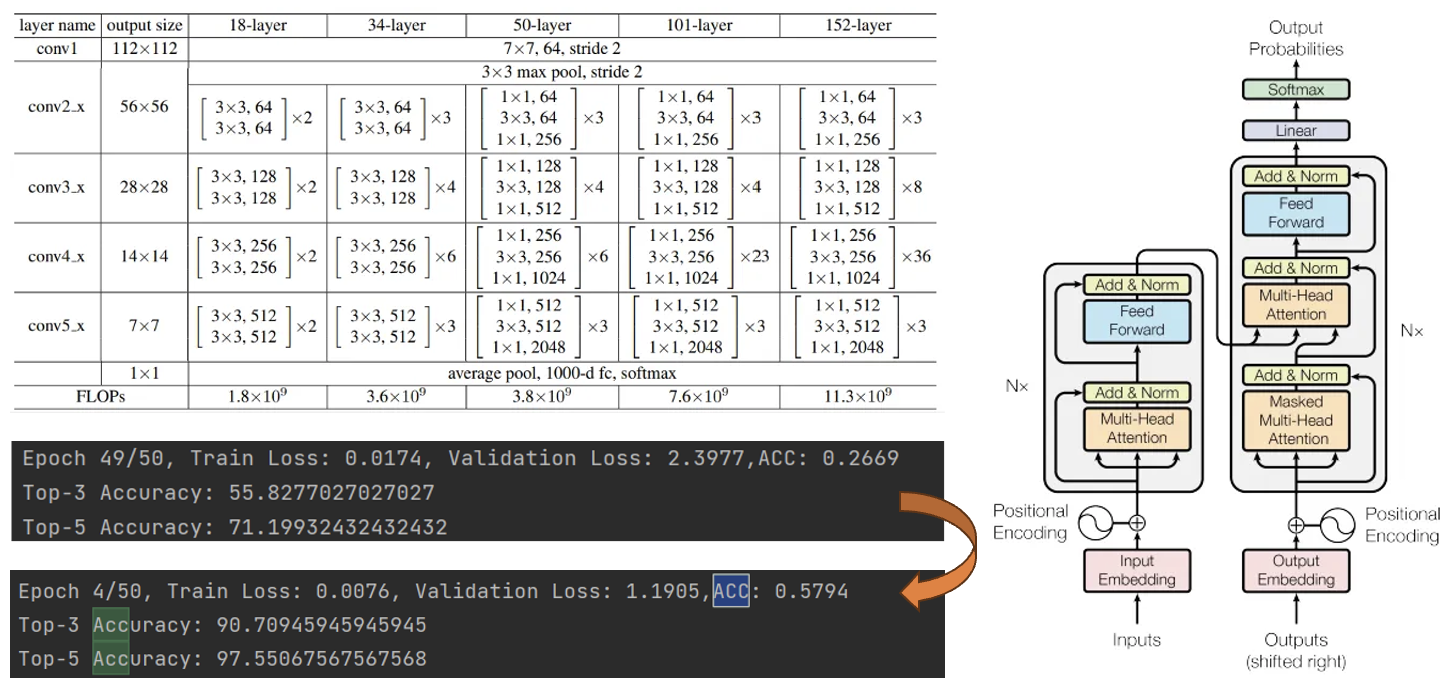